Here, we will be looking at a paper [@ZiLN] that uses <b style="color:#A6A440">metagenomics</b> data - specifically that of the LifeLines-DEEP gut microbiome data [@lifelines-deep].

Specifically, we want to recreate the following image:

![A network of microbial associations.  Not own work.](./images/ziln-graph.png)

In [ ]:
# This gives us a 1135x3957 matrix (people x species) of 16s rRNA counts `counts`
# And a dataframe `taxmat` of 3957 rows giving taxonomic information
load("localdata/ll_deep.rda")

Interestingly, there seem to be too many species!  There are 3957 species here but there're clearly less than that in the graph^[In fact, I hand-counted them and got 500ish].  The paper does have this to say about it:

> To simplify the plot, a threshold was applied here to remove taxa absent in more than 20% of the samples, leading to a total of 565 species.
>
> <b style="color:#EB1960">Caption on Figure 5 [@ZiLN]</b>

Frustratingly, the image we want to recreate is actually <b style="color:#EB1960">Figure 4</b> in the paper.  Since both figures are interrelated and both are part of the short section "<b style="color:#EB1960">Inference of real-world microbial association networks</b>", I think it's reasonable that this filtering method was used for both.  It is pretty annoying that it's not more clear, though.

In [ ]:
# This is their own filtering code, from:
# https://github.com/vincentprost/Zi-LN/blob/master/venn.R
# Although I've broken it up a bit to make it more amenable to commenting

# Get a boolean 1135x3957 matrix of whether the species
# was found in the person or not
nonzeros <- counts > 0

# Get the number of distinct people that possessed each species
num.nonzeros <- apply(nonzeros, 2, sum)

# Get the total amount of people
total.cells <- dim(counts)[1]

# Only keep the species who appear in more than 20% of the people
keep.indices <- (num.nonzeros / total.cells) > 0.2
counts_el <- as.matrix(counts[, keep.indices])
taxmat_el <- taxmat[keep.indices,]

# We should now only be looking at 565 species
dim(counts_el)

[1] 1135  565

Now that we have the data filtered in what we hope is the same manner as the paper, we can try to run their analysis.  At  a high level, the key idea of this paper is to model the data as being some transform of a <b style="color:#A6A440">gaussian latent variable</b> $z$.  They wrote a function `infer_Z` to estimate the latent $z$, after which they can use a technique to estimate the <b style="color:#A6A440">precision matrix</b>, which should give us the association network for the microbes[^I haven't done a blog post on <b style="color:#A6A440">Gaussian Graphical Models</b> before, but I should...  This section will make more sense if you have a background in them.].

In [ ]:
# Load the code from the paper
source("./localdata/Zi-LN-master/inference.R")
source("./localdata/Zi-LN-master/utils/utils.R")

In [ ]:
# Get the zs
options(warn = -1) # turn warnings off because otherwise it's gonna scream...
zs <- infer_Z(counts_el)
dim(zs)

[1] 1135  565

Now we need to infer the <b style="color:#A6A440">precision matrix</b>.  We're stuck again referring to their methodology for <b style="color:#A6A440">Figure 5</b>.  Even more annoyingly, they do not use the regularization parameter that they used, but rather just say that they kept the top 1200 edges.  So I had to run manual experiments to find out!  Spoiler alert, the parameter is $\lambda = 0.251$

In [ ]:
# Desired sparsity level (multiply by 2 b/c symmetric)
(2 * 1200) / (565*565)

[1] 0.007518208

In [ ]:
library("huge")
library("igraph")

In [ ]:
precision.matrix <- huge(zs, lambda = 0.251)

Conducting Meinshausen & Buhlmann graph estimation (mb)....done


In [ ]:
precision.matrix

Model: Meinshausen & Buhlmann graph estimation (mb)
Input: The Data Matrix
Path length: 1 
Graph dimension: 565 
Sparsity level: 0.007531538 -----> 0.007531538 

In [ ]:
associations <- precision.matrix$path[[1]]

# Number of edges, to verify we've done it right
sum(associations) / 2

[1] 1200

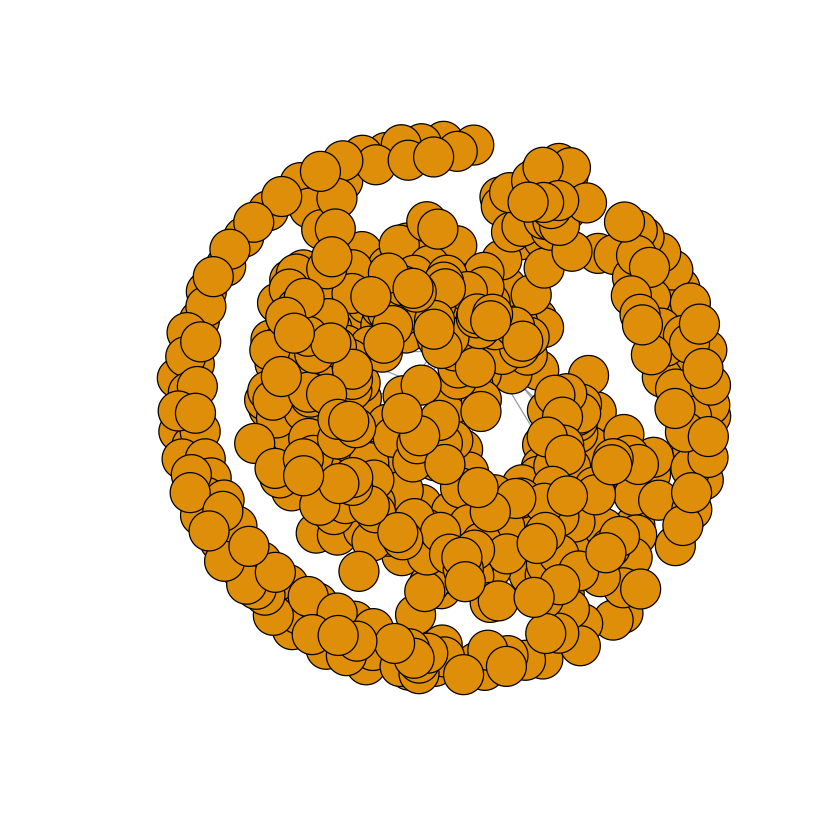

In [ ]:
adjacency.graph = graph.adjacency(associations, mode = "undirected")
plot(adjacency.graph)

There we go, we've plotted it!  But wait...  It looks rather crappy.  I guess we'll have to work a bit to make it nice.

In [ ]:
# Add a "color" column to prepare for coloring graph nodes
taxmat.colors <- cbind(taxmat_el, "#000000")
colnames(taxmat.colors)[length(colnames(taxmat.colors))] <- "color"

In [ ]:
taxa.level <- "V5"
unique.taxa <- unique(taxmat.colors[,taxa.level])
num.taxa <- length(unique.taxa)
increment <- 89 / (num.taxa-1)
increments <- 10 + round(increment * 0:(num.taxa-1))
hex.map <- paste("#19", increments, "60", sep="")
for (i in 1:num.taxa) {
    taxmat.colors[
        unique.taxa[i]==taxmat.colors[,taxa.level],
        "color"
    ] <- hex.map[i]
}

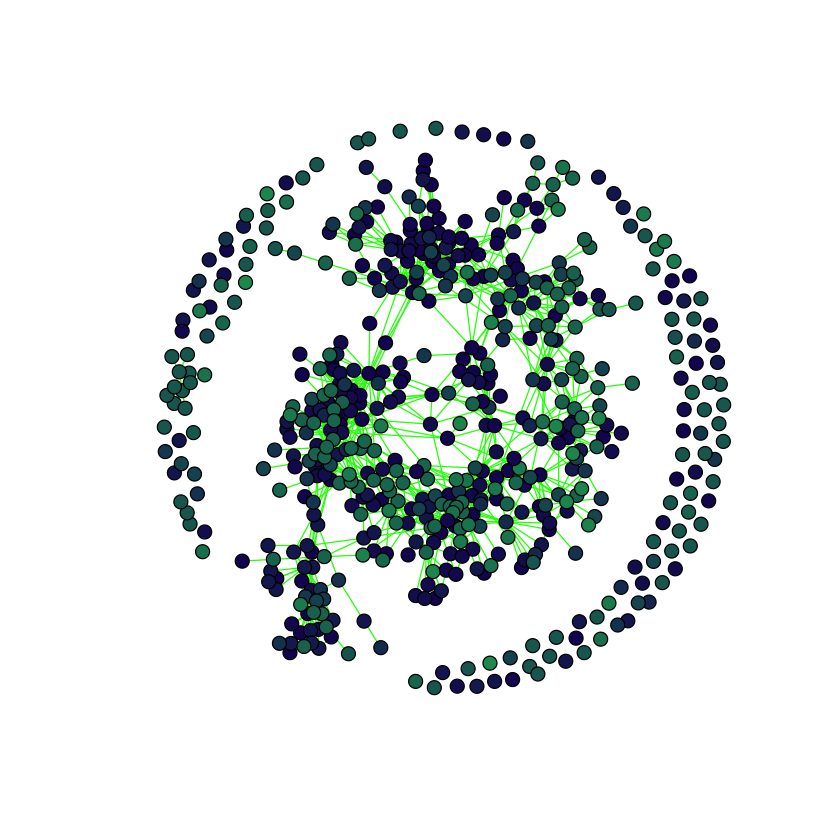

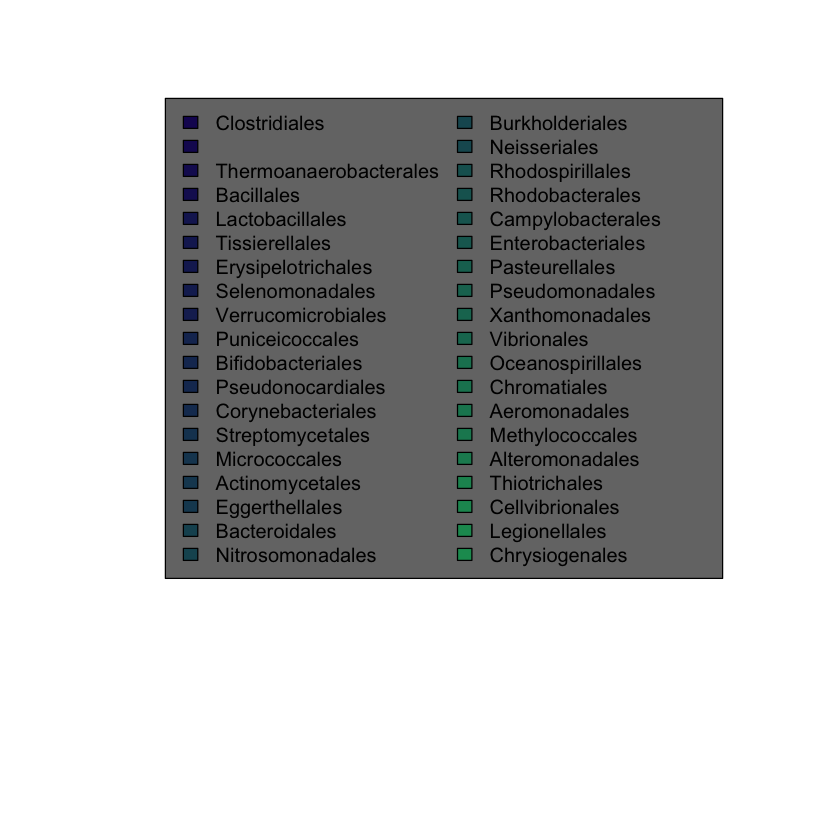

In [ ]:
plot(
    adjacency.graph,
    edge.color = "green",
    vertex.size = 5,
    vertex.label = "",
    vertex.color = taxmat.colors[,"color"],
    margin=c(0, 0, 0, 0)
)
plot(
    adjacency.graph,
    vertex.label.color = "#00000000",
    vertex.color = "#00000000",
    edge.color = "#00000000",
    vertex.frame.color = "#00000000"
)
legend('top',
       legend = unique.taxa,
       bg = "#757575",
       fill = hex.map,
       ncol = 2
)

This seems close enough.  We do end up with much more disconnected species, and I don't really understand why because in their code they literally run:

```{R}
do.call(huge::huge, c(lambda = l, list(x = X, method = "mb", verbose = T)))
```

Where `l` is whatever lambda value causes 1200 edges.  That code, however, is for <b style="color:#EB1960">Figure 5</b> whereas we want to replicate <b style="color:#EB1960">Figure 4</b>; perhaps they chose a different `l` for <b style="color:#EB1960">Figure 4</b>?  But we'll stop here for now.